# **Practical Time Series Forecasting with R**
## Chapter 9: Neural Networks

In [2]:
## ESTABLISH ENVIRONMENT
# Built-in libraries
from datetime import datetime
from pathlib import Path

# Third-party libraries for data handling and scientific computation
import numpy as np
import pandas as pd

# Libraries for statistical and econometric model_NeuralNet_NeuralNets
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Libraries for preprocessing and visualization
from sklearn.preprocessing import PolynomialFeatures, MinMaxScaler
from sklearn.metrics import mean_squared_error
import matplotlib.dates as mdates
import matplotlib.pyplot as plt

# Keras libraries for deep learning
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam

## AMTRAK IMPORT FORMATTING
def convert_date(date_str):
    # if the string is 'nan' (which can occur if there was a NaN entry in the original data)
    if date_str == 'nan':
        return None
    # try to parse the date assuming it's in the format 'Dec-00'
    try:
        date = datetime.strptime(date_str, '%b-%y')
        if date.year > datetime.now().year:
            date = date.replace(year=date.year-100) # replace century if needed
    except ValueError:
        # if that fails, assume it's in the format '1-Dec'
        try:
            date = datetime.strptime(date_str, '%d-%b')
            # assuming all dates are in 2000s
            date = date.replace(year=2000 + int(date_str.split('-')[0]))
        except ValueError:
            # if both formats fail, return None or handle as you see fit
            return None
    # convert the date into the desired format
    return date.strftime('%B %Y')


## AMTRAK GRAPH FORMATTING
def Amtrak_PlotGraph(train, valid, pred_dict_train, pred_dict_valid, **kwargs):
    TextHight = kwargs.get('TextHight', 2600) # Default value is 2600 if not provided
    fig, ax = plt.subplots()

    # Define color palette with distinct colors
    color_palette = plt.cm.get_cmap('tab10', 10)
    
    ax.plot(train.index, train, label='Training Data', linewidth=2, color=color_palette(0))
    ax.plot(valid.index, valid, label='Validation Data', color=color_palette(0))
    
    for i, (label, pred) in enumerate(pred_dict_train.items()):
        ax.plot(train.index, pred, label=label + ' Training', linewidth=2, linestyle='--', color=color_palette(i+1))  # Using different colors for different models

    for i, (label, pred) in enumerate(pred_dict_valid.items()):
        ax.plot(valid.index, pred, label=label + ' Validation', linewidth=2, linestyle='--', color=color_palette(i+1))  # Using different colors for different models

    ax.axvline(train.index[-1], color='black', linestyle='solid')
    ax.axvline(valid.index[-1], color='black', linestyle='solid')

    ax.text(train.index[int(len(train)/2)], TextHight, 'Training', horizontalalignment='center')
    ax.text(valid.index[int(len(valid)/2)], TextHight, 'Validation', horizontalalignment='center')
    ax.text(valid.index[-1] + pd.DateOffset(months=11), TextHight, 'Future', horizontalalignment='center')
    
    ax.annotate("", xy=(pd.to_datetime('1991-01-01'), TextHight-50), xytext=(train.index[-1], TextHight-50), arrowprops=dict(arrowstyle="<->"))
    ax.annotate("", xy=(train.index[-1], TextHight-50), xytext=(valid.index[-1], TextHight-50), arrowprops=dict(arrowstyle="<->"))
    ax.annotate("", xy=(valid.index[-1], TextHight-50), xytext=(valid.index[-1] + pd.DateOffset(months=20), TextHight-50), arrowprops=dict(arrowstyle="<->"))

    ax.set_xlabel('Time')
    ax.set_ylabel('Ridership')
    ax.set_ylim([1300, 2600])

    years = mdates.YearLocator()
    years_fmt = mdates.DateFormatter('%y')
    ax.xaxis.set_major_locator(years)
    ax.xaxis.set_major_formatter(years_fmt)

    for spine in ['top', 'right']:
        ax.spines[spine].set_visible(False)

    ax.legend()
    plt.show()

## AMTRAK RESIDUAL FORMATTING
def Amtrak_PlotResidualsGraph(train_residuals, valid_residuals, **kwargs):
    fig, ax = plt.subplots()

    # Define color palette with distinct colors
    color_palette = plt.cm.get_cmap('tab10', 10)
    
    ax.plot(train_residuals.index, train_residuals, label='Training Residuals', linewidth=2, color=color_palette(0))
    ax.plot(valid_residuals.index, valid_residuals, label='Validation Residuals', linewidth=2, color=color_palette(0))
    
    ax.axvline(train_residuals.index[-1], color='black', linestyle='solid')
    ax.axvline(valid_residuals.index[-1], color='black', linestyle='solid')

    # Dynamically set the text and arrows to always be above the data points
    ymax = ax.get_ylim()[1]
    TextHight = ymax + (0.1 * ymax)
    ArrowHight = TextHight - (0.05 * ymax)

    ax.text(train_residuals.index[int(len(train_residuals)/2)], TextHight, 'Training', horizontalalignment='center')
    ax.text(valid_residuals.index[int(len(valid_residuals)/2)], TextHight, 'Validation', horizontalalignment='center')
    ax.text(valid_residuals.index[-1] + pd.DateOffset(months=11), TextHight, 'Future', horizontalalignment='center')

    # Add arrows spanning the width of the data periods
    ax.annotate("", xy=(train_residuals.index[0], ArrowHight), xytext=(train_residuals.index[-1], ArrowHight), arrowprops=dict(arrowstyle="<->"))
    ax.annotate("", xy=(train_residuals.index[-1], ArrowHight), xytext=(valid_residuals.index[-1], ArrowHight), arrowprops=dict(arrowstyle="<->"))
    ax.annotate("", xy=(valid_residuals.index[-1], ArrowHight), xytext=(valid_residuals.index[-1] + pd.DateOffset(months=20), ArrowHight), arrowprops=dict(arrowstyle="<->"))

    ax.set_xlabel('Time')
    ax.set_ylabel('Residuals')

    years = mdates.YearLocator()
    years_fmt = mdates.DateFormatter('%y')
    ax.xaxis.set_major_locator(years)
    ax.xaxis.set_major_formatter(years_fmt)

    for spine in ['top', 'right']:
        ax.spines[spine].set_visible(False)

    ax.legend()
    plt.show()

### IMPORTING DATA ###
# Define Path
Data_Repo = Path("/Users/[Insert Path to Data]/")

#Data
Amtrak_data = pd.read_csv(Data_Repo / "Amtrak data.csv", skipfooter=96, skip_blank_lines=True, comment='#', engine='python')
Amtrak_data['Month'] = Amtrak_data['Month'].astype(str) # Convert the 'Month' column to string type
Amtrak_data['Month'] = Amtrak_data['Month'].apply(convert_date) # Apply the date conversion function to the 'Month' column

##Ch2 >> Amtrak TimeSeries
ridership_ts = pd.Series(Amtrak_data["Ridership"].values, index=pd.date_range('1991-01', periods=len(Amtrak_data), freq='M'))
ridership_df = pd.DataFrame(Amtrak_data["Ridership"].values, index=pd.date_range('1991-01', periods=len(Amtrak_data), freq='M'), columns=['ridership'])


2/2 [==============================] - 0s 6ms/step

--- Training Set Performance ---
Mean Error (ME): 0.3884703220274321
Root Mean Squared Error (RMSE): 4.297932068522392
Mean Absolute Error (MAE): 3.625351324314017
Mean Percentage Error (MPE): 0.0036766170010899043
Mean Absolute Percentage Error (MAPE): 0.2058220534199733
Mean Absolute Scaled Error (MASE): 0.02893394401314525

--- Validation Set Performance ---
Mean Error (ME): 6.659761013454853
Root Mean Squared Error (RMSE): 7.960224353970688
Mean Absolute Error (MAE): 6.93264436848958
Mean Percentage Error (MPE): 0.3195451645030722
Mean Absolute Percentage Error (MAPE): 0.3353271022100605
Mean Absolute Scaled Error (MASE): 0.05664485768365854


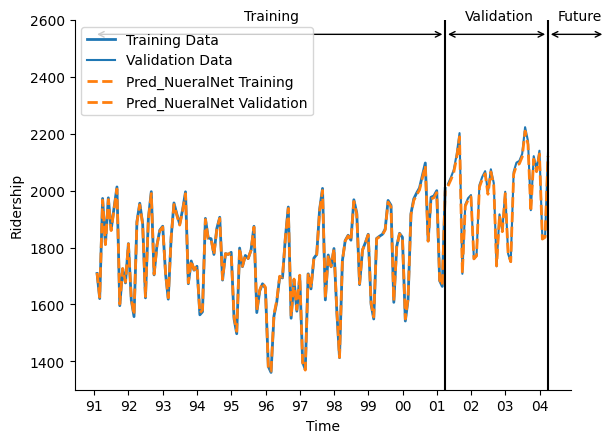

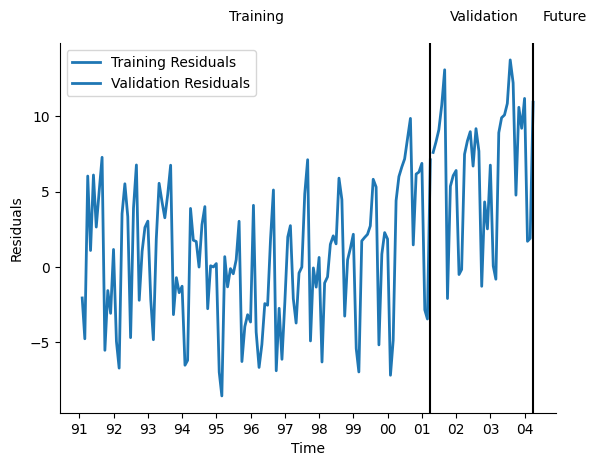

In [3]:
## Figure 9.5: Neural Network autoression fitted to the Amtrak Ridership data in the training period & forecasted in the validation period
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
import numpy as np

# Function to compute the performance metrics
def compute_metrics(y_true, y_pred, dataset_name):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    mape = mean_absolute_percentage_error(y_true, y_pred) * 100  # scale to percentage
    me = np.mean(y_true - y_pred)
    mpe = np.mean((y_true - y_pred) / y_true) * 100
    mase = mae / (np.abs(y_true - y_true.shift()).mean())  # Assuming y_true is a pd.Series

    print(f'\n--- {dataset_name} Set Performance ---')
    print(f'Mean Error (ME): {me}')
    print(f'Root Mean Squared Error (RMSE): {rmse}')
    print(f'Mean Absolute Error (MAE): {mae}')
    print(f'Mean Percentage Error (MPE): {mpe}')
    print(f'Mean Absolute Percentage Error (MAPE): {mape}')
    print(f'Mean Absolute Scaled Error (MASE): {mase}')

# Define the size of your validation set
nValid = 36
nTrain = len(ridership_ts) - nValid

# Split your data into training and validation sets
train = ridership_ts.iloc[:nTrain]
valid = ridership_ts.iloc[nTrain:nTrain + nValid]

# Normalize the data
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train.values.reshape(-1, 1))
valid_scaled = scaler.transform(valid.values.reshape(-1, 1))

# Define the neural network model
model_neuralnet = Sequential()
model_neuralnet.add(Dense(7, input_dim=1, activation='relu'))
model_neuralnet.add(Dense(1))
model_neuralnet.compile(loss='mean_squared_error', optimizer=Adam())

# Train the model
model_neuralnet.fit(train_scaled, train_scaled, epochs=20, batch_size=1, verbose=0)

# Make predictions
train_pred = model_neuralnet.predict(train_scaled).flatten()
valid_pred = model_neuralnet.predict(valid_scaled).flatten()

# Transform predictions back to original scale
train_pred = scaler.inverse_transform(train_pred.reshape(-1, 1)).flatten()
valid_pred = scaler.inverse_transform(valid_pred.reshape(-1, 1)).flatten()

# Compute the metrics for the training set
compute_metrics(train, train_pred, 'Training')

# Compute the metrics for the validation set
compute_metrics(valid, valid_pred, 'Validation')

# Store your predictions
pred_dict_train = {'Pred_NueralNet': train_pred}
pred_dict_valid = {'Pred_NueralNet': valid_pred}

# Visualize your predictions
Amtrak_PlotGraph(train, valid, pred_dict_train, pred_dict_valid, TextHight=2600)

## RESIDUALS
# Calculate & Store residuals
train_residuals = pd.Series((train.values.flatten() - train_pred.flatten()), index=train.index)
valid_residuals = pd.Series((valid.values.flatten() - valid_pred.flatten()), index=valid.index)

# Visualize Residuals
Amtrak_PlotResidualsGraph(train_residuals, valid_residuals)
